<a href="https://colab.research.google.com/github/albivaltzew/NLP_CV_DC_ITMO/blob/main/Unit_10_spatial_filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В этом блокноте мы изучим некоторые приемы коррекции яркости, цвета изображения, а также поговорим про фильтрацию изображений. Для начала установим нужную версию библиотеки и подключим необходимое.

In [ ]:
!pip install opencv-python==4.4.0.42

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 MB 11.7 MB/s eta 0:00:00
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.6.0.66
    Uninstalling opencv-python-4.6.0.66:
      Successfully uninstalled opencv-python-4.6.0.66


In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## **Гистограмма и ее построение**

Начнем с построения гистограммы изображения. Для начала загрузим исходное изображение и посмотрим на него. Напомним, что изображение загружается в палитре BGR, поэтому, чтобы цвета на изображении были "исходными", перейдем к цветовому пространству RGB.

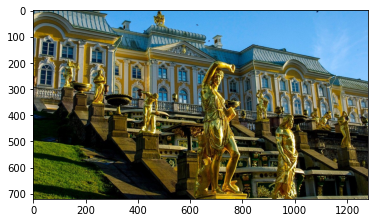

In [ ]:
img = cv2.imread('pet.jpg')
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img)

Рассмотрим это же изображение в черно-белом формате. В этом формате каждый пиксель характеризуется своей интенсивностью, задаваемой целым числом в диапазоне $0 - 255$.

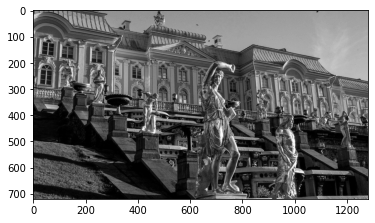

In [ ]:
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_img, cmap='gray')

"Построим" гистограмму (на самом деле — график гистограммы) черно-белого изображения. Гистограмма черно-белого изображения — это функция $h(n)$, принимающая целое число $n$ (интенсивность) в диапазоне $0 - 255$, и выдающая количество пикселей изображения с интенсивностью $n$. 

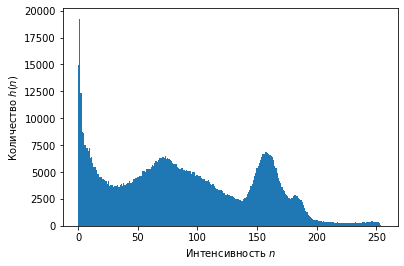

In [ ]:
gray_hist = plt.hist(gray_img.ravel(), bins = 256)
plt.xlabel('Интенсивность $n$')
plt.ylabel('Количество $h(n)$')
plt.show()

In [ ]:
max(gray_hist[0])

19248.0

In [ ]:
# gray_hist[0].index(19248.0)

In [ ]:
#  gray_hist


Мы видим, что самые часто встречающие пиксели - пиксели, имеющие цвет, близкий к черному (почти нулевую интенсивность). Кроме того, есть явное превалирование пикселей интенсивностью около $55$ и $200$.

В случае палитры RGB, мы можем построить гистограмму для каждого канала в отдельности. Тем самым, мы получим три функции: $h_{red}(n), h_{green}(n), h_{blue}(n)$, принимающие целое число $n$ (интенсивность) в диапазоне $0 - 255$, и выдающие количество пикселей изображения с интенсивностью $n$ соответвующего канала. Кроме того, мы можем построить суммарную гистограмму изображения $h(n) = h_{red}(n) + h_{blue}(n) + h_{green}(n)$.

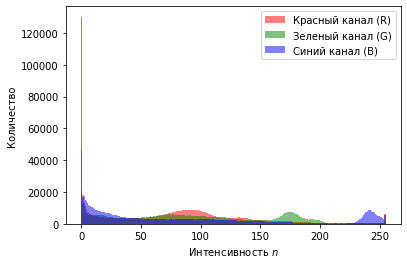

In [ ]:
plt.hist(RGB_img[:, :, 0].ravel(), bins = 256, color = 'Red', alpha = 0.5)
plt.hist(RGB_img[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
plt.hist(RGB_img[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
plt.legend(['Красный канал (R)', 'Зеленый канал (G)', 'Cиний канал (B)'])
plt.xlabel('Интенсивность $n$')
plt.ylabel('Количество')
plt.show()

Видно, что распределения интенсивностей по каналам очень похожи. Общее распределение интенсивности из-за этого тоже имеет весьма предсказуемую форму.

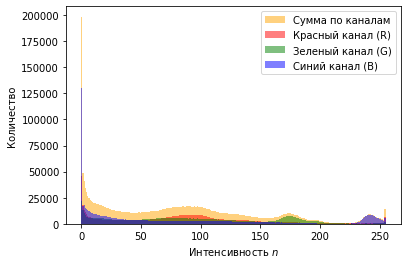

In [ ]:
plt.hist(RGB_img.ravel(), bins = 256, color = 'orange', alpha = 0.5) 
plt.hist(RGB_img[:, :, 0].ravel(), bins = 256, color = 'Red', alpha = 0.5)
plt.hist(RGB_img[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
plt.hist(RGB_img[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
plt.legend(['Сумма по каналам', 'Красный канал (R)', 'Зеленый канал (G)', 'Cиний канал (B)'])
plt.xlabel('Интенсивность $n$')
plt.ylabel('Количество')
plt.show()

Конечно, распределения разумно сравнивать, когда значения по оси ординат выражены частотой, в этом случае гистограмма — не что иное, как оценка плотности распределения интенсивностей.

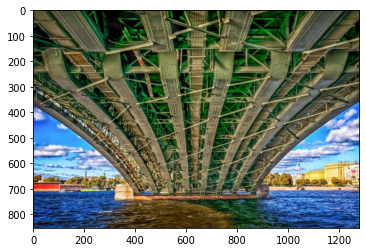

In [ ]:
img = cv2.imread('bridge.jpg')
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img)

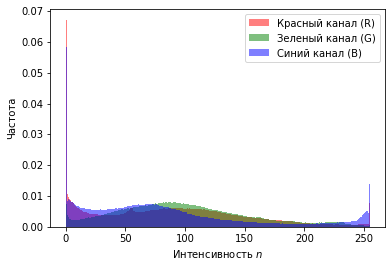

In [ ]:
plt.hist(RGB_img[:, :, 0].ravel(), bins = 256, color = 'Red', alpha = 0.5, density=True)
plt.hist(RGB_img[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5, density=True)
plt.hist(RGB_img[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5, density=True)
# plt.hist(RGB_img.ravel(), bins = 256, color = 'orange', alpha = 0.5, density=True) 
plt.legend(['Красный канал (R)', 'Зеленый канал (G)', 'Cиний канал (B)'])
plt.xlabel('Интенсивность $n$')
plt.ylabel('Частота')
plt.show()

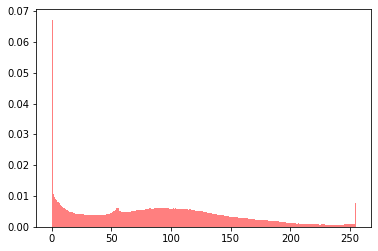

In [ ]:
red_hist = plt.hist(RGB_img[:, :, 0].ravel(), bins = 256, color = 'Red', alpha = 0.5, density=True)

In [ ]:
max(red_hist[0])

0.06718617106866194

## **Коррекция контрастности при помощи гистограммы**

Применим гистограмму для коррекции контрастности изображения.

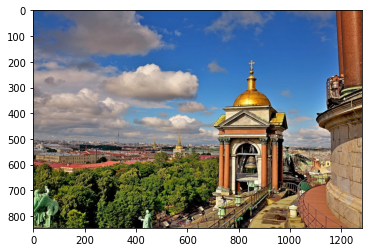

In [ ]:
img = cv2.imread('isaak.jpg')
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img)

Изображение очень блеклое. Построим гистограмму, например, синего канала (B).

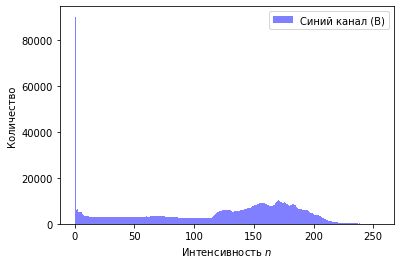

In [ ]:
plt.hist(RGB_img[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
plt.legend(['Синий канал (B)'])
plt.xlabel('Интенсивность $n$')
plt.ylabel('Количество')
plt.show()

Видно, что в изображении присутствуют далеко не все значения интенсивности. Исправим это, ипользуя, например, линейную нормировку. Для этого сначала сместим гистограмму так, чтобы она начиналась в нуле, а затем растянем на весь диапазон $0 - 255$.

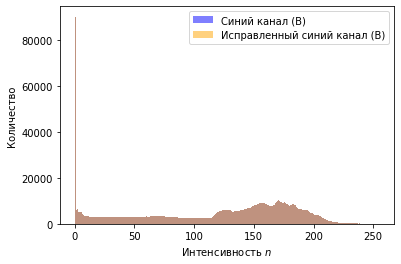

In [ ]:
plt.hist(RGB_img[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
plt.xlabel('Интенсивность $n$')
plt.ylabel('Количество')
RGB_img_new = RGB_img.copy()
RGB_img_new[:, :, 2] = (RGB_img_new[:, :, 2] - np.min(RGB_img_new[:, :, 2]))/(np.max(RGB_img_new[:, :, 2]) - np.min(RGB_img_new[:, :, 2]))*255
plt.hist(RGB_img_new[:, :, 2].ravel(), bins = 256, color = 'Orange', alpha = 0.5)
plt.legend(['Синий канал (B)', 'Исправленный синий канал (B)'])
plt.show()

Видно, что распределение несколько изменилось. Сделаем то же самое с остальными каналами и выведем исправленное изображение.

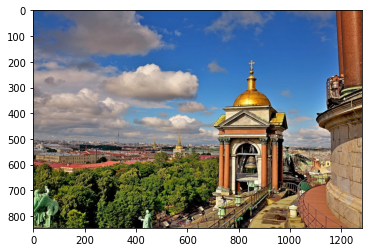

In [ ]:
RGB_img_new[:, :, 0] = (RGB_img_new[:, :, 0] - np.min(RGB_img_new[:, :, 0]))/(np.max(RGB_img_new[:, :, 0]) - np.min(RGB_img_new[:, :, 0]))*255
RGB_img_new[:, :, 1] = (RGB_img_new[:, :, 1] - np.min(RGB_img_new[:, :, 1]))/(np.max(RGB_img_new[:, :, 1]) - np.min(RGB_img_new[:, :, 1]))*255
plt.imshow(RGB_img_new)

In [ ]:
RGB_img_new[405, 615]

array([113, 165, 202], dtype=uint8)

Лучше, но все равно что-то не то. Совершенно понятно, что изображение, пиксели которого имеют тенденцию занимать весь диапазон возможных уровней интенсивности и, кроме того, обладают распределением, близким к равномерному распределению, будет обладать высокой контрастностью и будет демонстрировать большое разнообразие тонов. Конечно, линейное преобразование, описанноее ранее, вряд ли помогает равномерно "размазывать" интенсивность, оно лишь меняет диапазон интенсивностей. 

Есть много разных методов эквализации (или выравнивания) гистограммы. Покажем один из них.

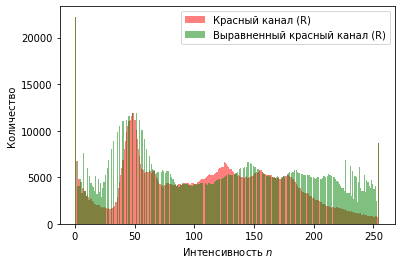

In [ ]:
plt.hist(RGB_img_new[:, :, 0].ravel(), bins = 256, color = 'Red', alpha = 0.5)
plt.xlabel('Интенсивность $n$')
plt.ylabel('Количество')
RGB_img_new[:, :, 0] = cv2.equalizeHist(RGB_img_new[:, :, 0]) 
plt.hist(RGB_img_new[:, :, 0].ravel(), bins = 256, color = 'Green', alpha = 0.5)
plt.legend(['Красный канал (R)', 'Выравненный красный канал (R)'])
plt.show()

Понятно, что зеленая гистограмма стала ближе к плотности желаемого равномерного распределения. Аналогично выравниваем остальные гистограммы и получаем следующий результат.

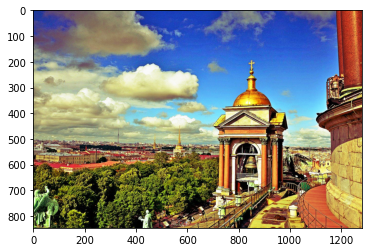

In [ ]:
RGB_img_new[:, :, 1] = cv2.equalizeHist(RGB_img_new[:, :, 1]) 
RGB_img_new[:, :, 2] = cv2.equalizeHist(RGB_img_new[:, :, 2]) 
plt.imshow(RGB_img_new)

## **Фильтрация изображений**

Научимся добавлять изображениям резкость. Для этого сначала научимся решать противоположную задачу — задачу размытия изображения. Необходимость размытия изображений часто возникает в предварительной обработке. Например, для успешной сегментации, часто стоит скрыть (размыть) мелкие несущественные детали.

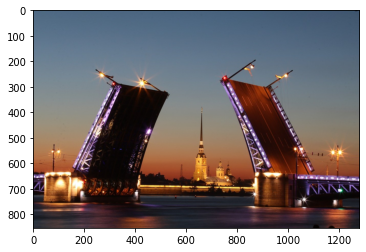

In [ ]:
img = cv2.imread('2bridge.jpg')
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img)

Размытие изображения достаточно просто осуществить, используя операцию свертки с некоторым ядром. Для примера, возьмем сначала такое ядро:
$$
K = \frac{1}{9}\begin{pmatrix}
1 & 1 & 1\\
1 & 1 & 1\\
1 & 1 & 1
\end{pmatrix}.
$$
То, что сумма элементов ядра равна $1$ гарантирует, что яркость изображения останется неизменной. Самое же ядро делает следующее: к применяемому пикселю (в центре) оно добавляет линейную комбинацию признаков пикселей вокруг  с одинаковыми весами.

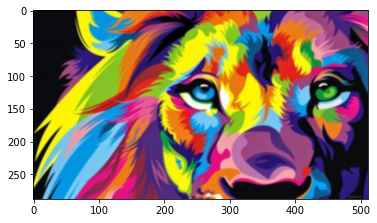

In [ ]:
kernel = np.ones((3, 3), np.float32) / 9
RGB_img_new = cv2.filter2D(RGB_img, -1, kernel)
plt.imshow(RGB_img_new)

Чтобы размытие было более заметным, применим ядро большего размера

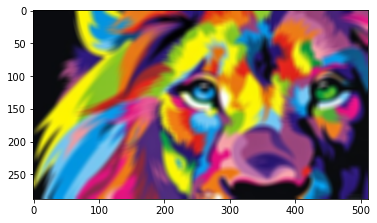

In [ ]:
kernel = np.ones((9, 9), np.float32) / 81
RGB_img_new = cv2.filter2D(RGB_img, -1, kernel)
plt.imshow(RGB_img_new)

Рассмотрим и такое ядро — аналог гауссова ядра:
$$
K = \frac{1}{16}\begin{pmatrix}
1 & 2 & 1\\
2 & 4 & 2\\
1 & 2 & 1
\end{pmatrix}
$$
и организуем свертку.

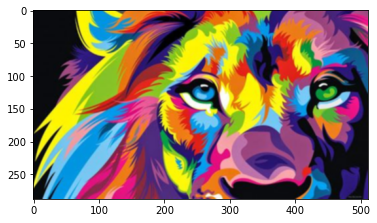

In [ ]:
kernel = np.ones((3, 3), np.float32) / 16
kernel[0][1] = kernel[1][0] =  kernel[1][2] = kernel[2][1] = 2/16
kernel[1][1] = 4/16
RGB_img_new = cv2.filter2D(RGB_img, -1, kernel)
plt.imshow(RGB_img_new)

Для применения гауссова ядра, можно воспользоваться специальным методом cv2.GaussianBlur(). Можно создать и гауссово ядро непосредственно, ипользуя cv2.getGaussianKernel().

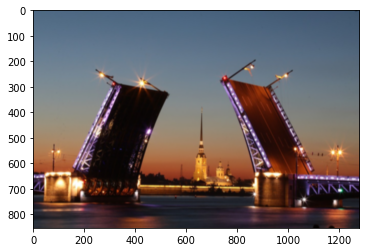

In [ ]:
RGB_img_new = cv2.GaussianBlur(RGB_img, (5,7), 3)
plt.imshow(RGB_img_new)

Помотрим, что остается, если вычесть из исходного резкого изображения размытую копию.

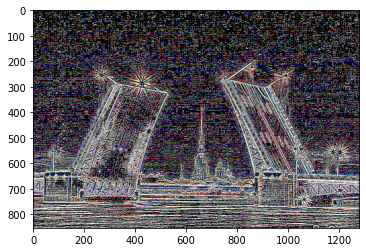

In [ ]:
RGB_img_remaining = RGB_img - RGB_img_new
plt.imshow(RGB_img_remaining)

Перед нами — так называемое изображение с деталями. Ясно, что если его добавить к размытому изображению, то мы получим исходное резкое изображение. Но что делать, если исходное изображение уже размыто? Размоем его еще немного и помотрим на изображение с деталями.

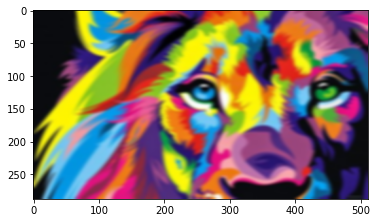

In [ ]:
kernel = np.ones((3, 3), np.float32) / 16
kernel[0][1] = kernel[1][0] =  kernel[1][2] = kernel[2][1] = 2/16
kernel[1][1] = 4/16
RGB_img_new2 = cv2.filter2D(RGB_img_new, -1, kernel)
plt.imshow(RGB_img_new2)

Теперь рассмотрим разность и будем добавлять ее к исходному размытому изображению с некоторыми коэффициентами.

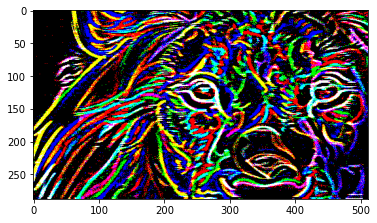

In [ ]:
RGB_img_remaining = RGB_img_new - RGB_img_new2
plt.imshow(RGB_img_remaining)

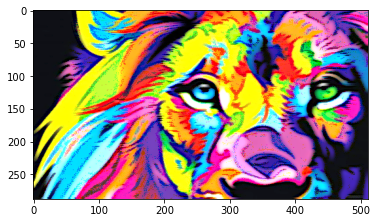

In [ ]:
RGB_img_final = cv2.addWeighted(RGB_img_new, 1.5, RGB_img_remaining, -0.5,0)
plt.imshow(RGB_img_final)

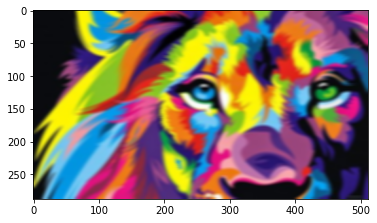

In [ ]:
plt.imshow(RGB_img_new)

Видно, что резкость увеличилась. Еще один способ увеличить резкость — применить специальное ядро. Например, такое:
$$
K = \begin{pmatrix}
-1 & -1 & -1 \\
-1 & 9 & -1 \\
-1 & -1 & -1
\end{pmatrix}.
$$
Давайте посмотрим на результат.

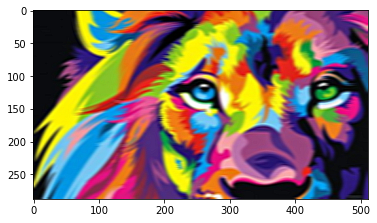

In [ ]:
kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
RGB_img_final2 = cv2.filter2D(RGB_img_new, -1, kernel)
plt.imshow(RGB_img_final2)

Резкость увеличена. Другие примеры ядер можно посмотреть, например, по [ссылке](https://en.wikipedia.org/wiki/Kernel_(image_processing).

Напоследок научимся очищать изображения. Рассмотрим черно-белые изображения с шумом типа "соль и перец" — случайные пиксели изображения перекрашены либо в белый, либо в черный цвета. На изображении ниже не видно практически ничего. Хотя основной объект, конечно, угадывается.

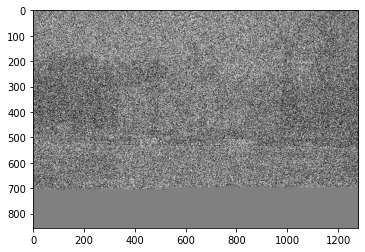

In [ ]:
img = cv2.imread('waf.jpg')
plt.imshow(img)

Применим медианный фильтр `cv2.medianBlur(source, ksize)`. Второй аргумент `ksize` принимает нечетные значения, начиная с $3$ и отвечает за "размер окрестности" — матрицы вокруг пикселя, элементы которой используются для поиска медианы.


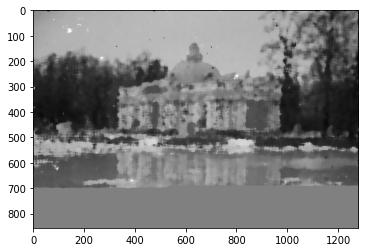

In [ ]:
img_final = cv2.medianBlur(img, 17)
plt.imshow(img_final)

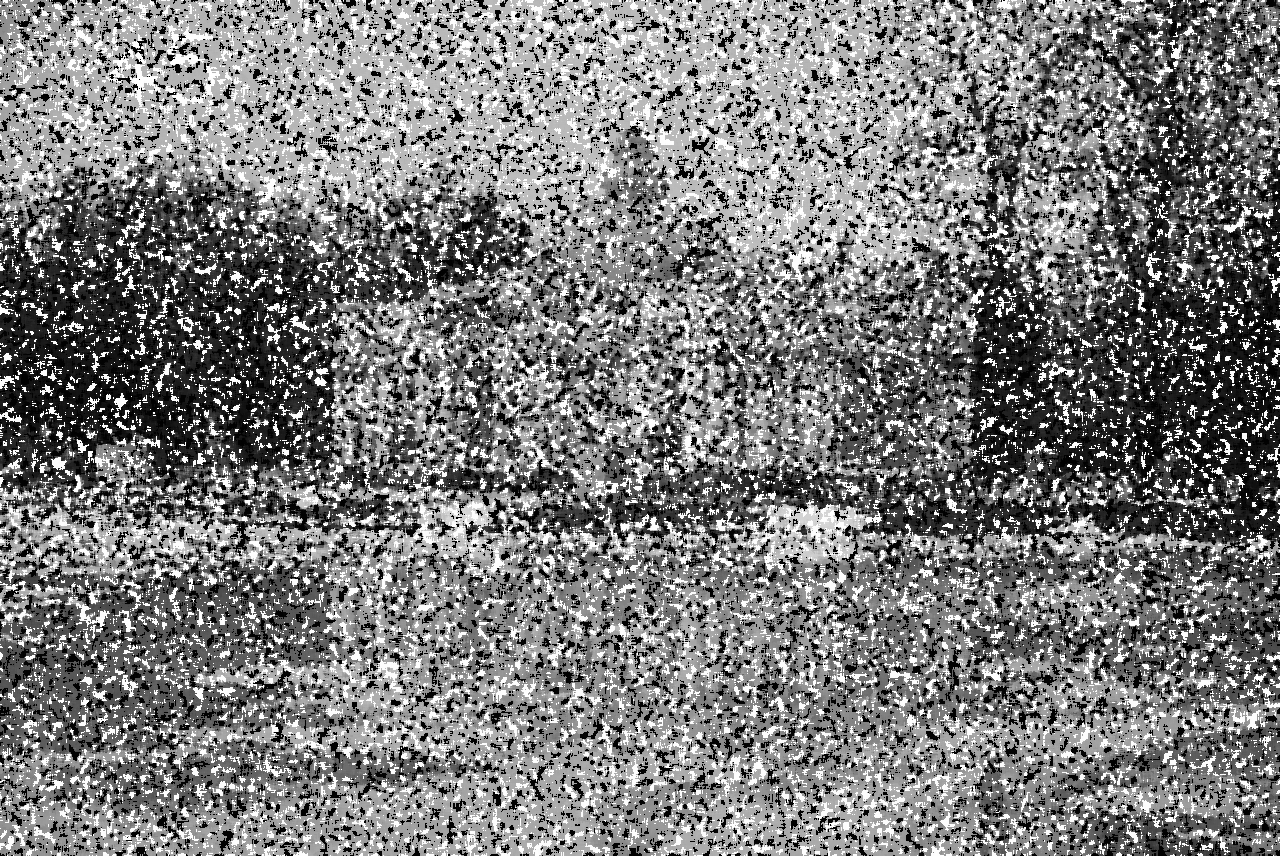

In [ ]:
from google.colab.patches import cv2_imshow
img = cv2.imread('waf.jpg')
img_final = cv2.medianBlur(img, 5)

cv2_imshow(img_final)

С другими фильтрами можно ознакомиться в дополнительных материалах.

